In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2|

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
import tensorflow as tf
from epi.SC_Circuit_inputs import SC_acc_diff, SC_acc, SC_sim, unwrap
DTYPE = tf.float32

### 1. Define the V1Circuit model

In [2]:
lb = -.2
ub = .2

E_constant = Parameter("E_constant", 1, lb=lb, ub=ub)
E_Pbias = Parameter("E_Pbias", 1, lb=lb, ub=ub)
E_Prule = Parameter("E_Prule", 1, lb=lb, ub=ub)
E_Arule = Parameter("E_Arule", 1, lb=lb, ub=ub)
E_choice = Parameter("E_choice", 1, lb=lb, ub=ub)
E_light = Parameter("E_light", 1, lb=lb, ub=ub)
opto_strength = Parameter("opto_strength", 1, lb=lb, ub=ub)

parameters = [E_constant, E_Pbias, E_Prule, E_Arule, E_choice, E_light, opto_strength]

model = Model("SC_Circuit", parameters)

### 2. Define eps function using Euler

In [3]:
model.set_eps(SC_acc_diff)

def accept_inds(T_x, means, stds):
    acc = np.array([np.logical_and(means[i] - 2*stds[i] < T_x[:,i],
                    T_x[:,i] < means[i] + 2*stds[i]) for i in range(len(means))])
    return np.logical_and.reduce(acc, axis=0)

UnboundLocalError: local variable 'I_constant' referenced before assignment

In [8]:
num_keep = 200
M = 1000
zs = []
T_xs = []

means = [0., -0.25]
stds = [0.01, 0.01]

num_found = 0
z = None
T_x = None
while (num_found < num_keep):
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')

    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20
z_labels = [r"$sW_P$",  r"$sW_A$",  r"$vW_{PA}$", r"$vW_{AP}$", 
            r"$dW_{PA}$", r"$dW_{AP}$", r"$hW_P$",  r"$hW_A$"]


ValueError: shape mismatch: value array of shape (1,1000,1,1,1) could not be broadcast to indexing result of shape (17,1,2,1,1)

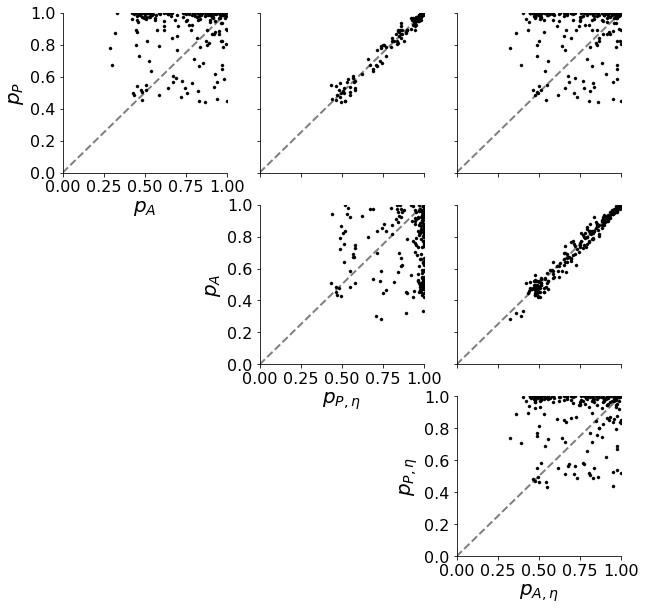

In [24]:
p = SC_acc(*unwrap(z)).numpy()
p[:,1] = 1.-p[:,1]
p[:,3] = 1.-p[:,3]
p_labels = [r'$p_P$', r'$p_A$', r'$p_{P,\eta}$', r'$p_{A,\eta}$']
fig, axs = pairplot(p[:num_plot], np.arange(4), p_labels,
               fontsize=fontsize, figsize=(10,10),
               lb=np.zeros((4,)), ub=np.ones((4,)))

for i in range(3):
    for j in range(i,3):
        axs[i][j].plot([0,1], [0,1], 'k--', alpha=0.5)
    
        

In [ ]:
num_keep = 200
M = 1000
zs = []
T_xs = []

means = [0., -0.2]
stds = [0.01, 0.01]

num_found = 0
z = None
T_x = None
while (num_found < num_keep):
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')

    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20
z_labels = [r"$sW_P$",  r"$sW_A$",  r"$vW_{PA}$", r"$vW_{AP}$", 
            r"$dW_{PA}$", r"$dW_{AP}$", r"$hW_P$",  r"$hW_A$"]


In [16]:
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])

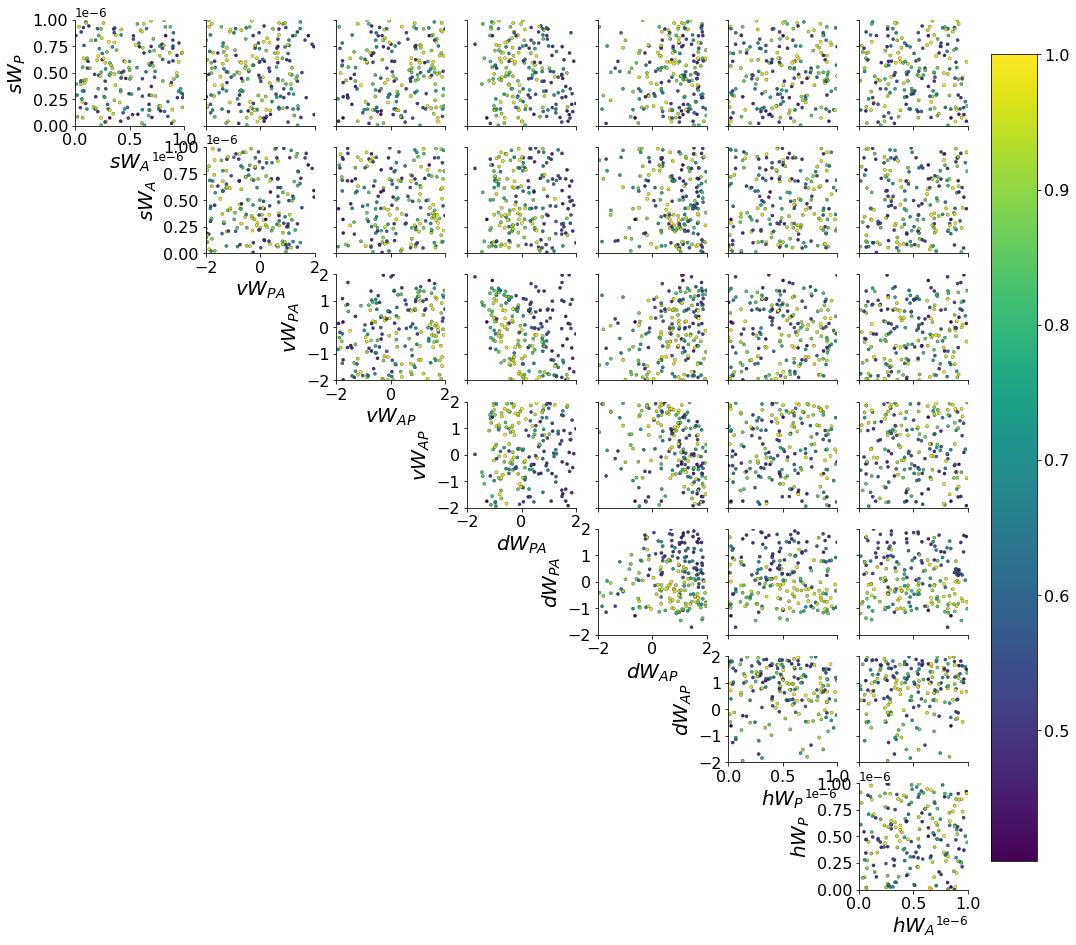

In [17]:
fig = pairplot(z[:num_plot], np.arange(8), z_labels,
               fontsize=fontsize, figsize=(16,16),
               lb=_lb, ub=_ub, c = p[:,1])

[0.7181025  0.44043237 0.76319635 0.7535701 ]


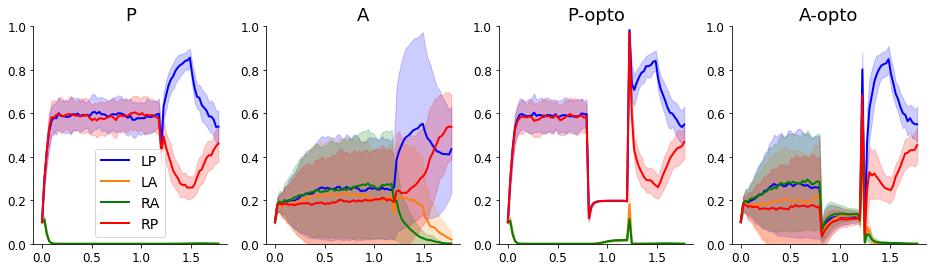

[0.7836479  0.41818115 0.7188164  0.72957397]


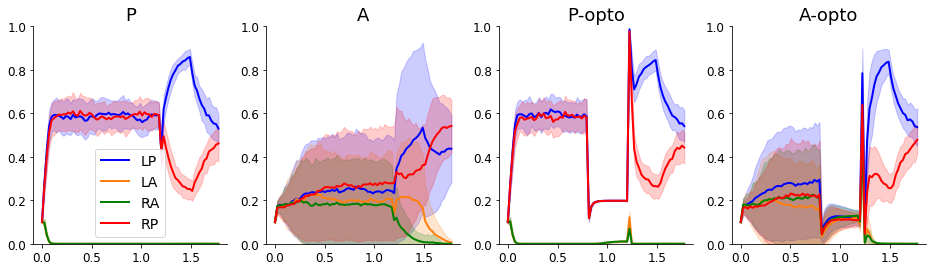

[0.75367785 0.5232355  0.7274592  0.7341099 ]


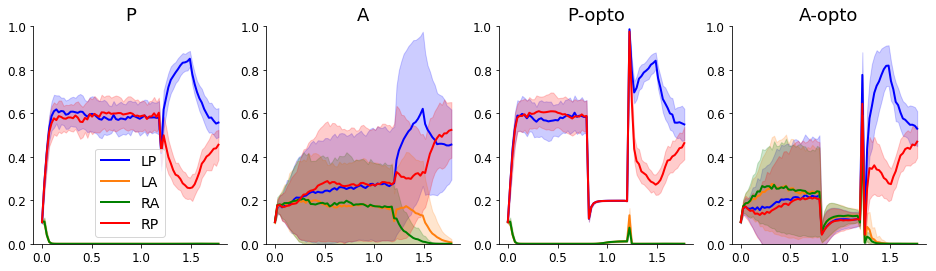

[0.77811074 0.50002855 0.7372504  0.67121935]


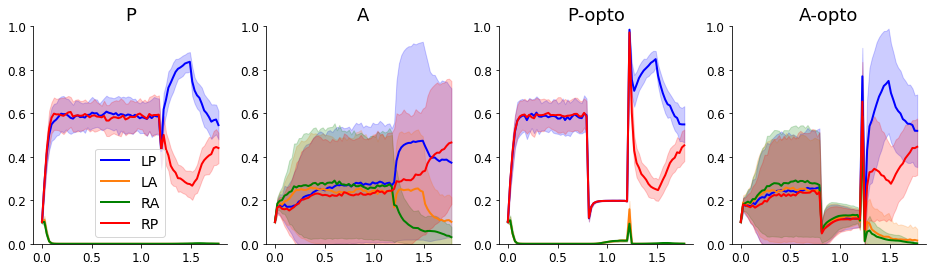

[0.7478351  0.53180915 0.72388244 0.7390252 ]


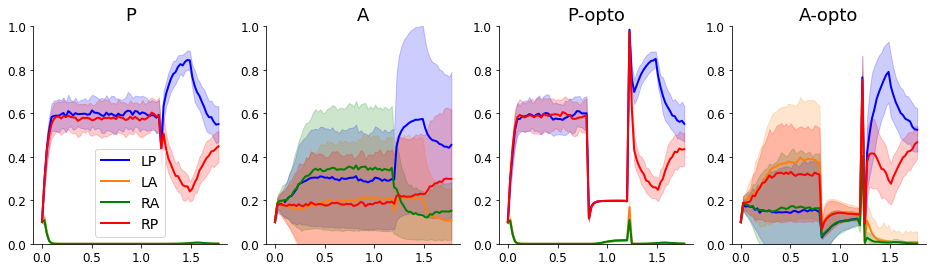

In [55]:
p = SC_acc(*unwrap(z)).numpy()

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)

u_t, v_t = SC_sim(*unwrap(z))
neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = ['b', 'tab:orange', 'g', 'r']
C_titles = ['P', 'A', 'P-opto', 'A-opto']
for m in range(min(z.shape[0], 5)):
    print(p[m])
    fig, axs = plt.subplots(1,4,figsize=(16, 4))
    for c in range(4):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
    axs[0].legend()
    plt.show()


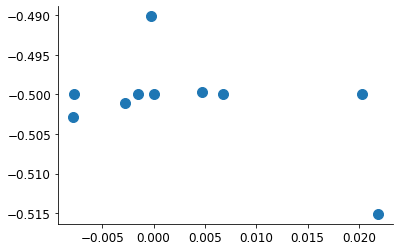

In [22]:
plt.scatter(T_x[:,0], T_x[:,1])

In [11]:
T_xs = []
N_samp = 250
for i in range(N_samp):
    T_xs.append(model.eps(z))
    
T_xs = np.stack(T_xs, axis=0)
print(T_xs.shape)

KeyboardInterrupt: 

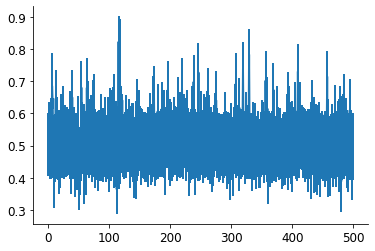

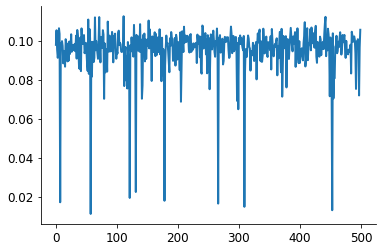

In [22]:
p_mean = np.mean(T_xs, axis=0)
p_std = np.std(T_xs, axis=0)
plt.figure()
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,0], p_std[:,0])
plt.show()

plt.figure()
plt.plot(np.arange(p_mean.shape[0]), p_std[:,0])
plt.show()